In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
# importing grid search
from sklearn.model_selection import GridSearchCV
# import our models
#Logistic Regression
from sklearn.linear_model import LogisticRegression
#linear SVC
from sklearn.svm import LinearSVC
#random forest
from sklearn.ensemble import RandomForestClassifier
#xgboost
from xgboost import XGBClassifier

#importing os
import os


plt.style.use("ggplot")

In [2]:
#%pip install xgboost

In [3]:
# Loading our data
data_base = pd.read_pickle('data_base.pkl')
data_base.head()

,date,home_team,away_team,season,home_win,home_rolling_fg,home_rolling_fga,home_rolling_fg%,home_rolling_3p,home_rolling_3pa,...,away_rolling_opponent_drb%_max,away_rolling_opponent_trb%_max,away_rolling_opponent_ast%_max,away_rolling_opponent_stl%_max,away_rolling_opponent_blk%_max,away_rolling_opponent_tov%_max,away_rolling_opponent_usg%_max,away_rolling_opponent_ortg_max,away_rolling_opponent_drtg_max,away_rolling_opponent_Total
0,2021-01-08,LAL,CHI,2020-21,1,44.000000,86.000000,0.510333,12.166667,31.500000,...,37.683333,25.166667,43.016667,5.083333,8.016667,47.266667,33.933333,193.000000,121.000000,119.333333
1,2021-01-09,MIL,CLE,2020-21,1,45.166667,88.666667,0.509833,16.666667,39.333333,...,37.966667,25.133333,48.700000,7.500000,6.566667,56.333333,31.833333,176.000000,109.500000,101.333333
2,2021-01-10,BRK,OKC,2020-21,0,44.666667,90.333333,0.493333,13.166667,36.166667,...,43.883333,25.016667,60.833333,5.333333,5.883333,47.533333,34.033333,169.833333,113.166667,106.500000
3,2021-01-10,GSW,TOR,2020-21,1,41.333333,87.500000,0.470833,14.000000,38.166667,...,44.950000,26.050000,48.866667,5.050000,12.916667,56.100000,32.033333,187.500000,123.166667,115.166667
4,2021-01-11,WAS,PHO,2020-21,1,44.000000,91.833333,0.479167,12.500000,34.833333,...,45.833333,25.966667,40.816667,4.550000,8.533333,38.566667,38.783333,208.333333,119.833333,108.166667


In [4]:
info_cols = ['date',
 'home_team',
 'away_team',
 'season',
 'home_win' ]


Creating our list of information columns. Note that these variables are all present before a game actually happens. 

In [5]:
# Splitting the data into train and test
X = data_base.loc[:, ~data_base.columns.isin(info_cols)] # excluding info_cols
y = data_base['home_win']

print(f'Feature set shape: {X.shape}, target series shape: {y.shape}')

Feature set shape: (2027, 264), target series shape: (2027,)


We need to perform Feature Scaling when we are dealing with Gradient Descent Based algorithms (Linear and Logistic Regression, Neural Network) and Distance-based algorithms (KNN, K-means, SVM) as these are very sensitive to the range of the data points.

In [15]:
#importing the data scaling and pipeline libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

#Creating a class that initializes the model and the parameters, and we just need to pass the scaling method for the pipeline

class ModelParams:
        """ Info:
         This class initializes the parameters and scalers for the models, which will be used for gridsearchcv,
         and their scaling methods.
          Input:
           model: the model to be used
            scaler: Default = False, if True, the model will be scaled accordily with its respective scaler
          Output:
           get_pipe: returns the model pipeline and its parameters
           model_name: returns the model name
             """
                
        #models_list = [LogisticRegression(random_state=42), LinearSVC(random_state=42), RandomForestClassifier(random_state=42), XGBClassifier(random_state=42)]     
    
        #creating the models  parameters dictionary
        # Parameters of pipelines can be set using '__' separated parameter names:
        
        models_params = {
            'LogisticRegression': {'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
                                      'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                                          'logisticregression__max_iter': [10000]},
            'LinearSVC': {'linearsvc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'linearsvc__loss': ['hinge', 'squared_hinge'],
                             'linearsvc__max_iter': [10000]},
            'RandomForestClassifier': {'randomforestclassifier__n_estimators': [100, 200, 300, 400, 500],
                                          'randomforestclassifier__criterion':['gini', 'entropy', 'log_loss'],
                                         'randomforestclassifier__max_depth': [None, 5, 10, 15, 20, 25, 30],
                                           'randomforestclassifier__min_samples_split': [None, 2, 5, 10],
                                             'randomforestclassifier__min_samples_leaf': [None, 1, 2, 4],
                                         'randomforestclassifier__max_features': ['sqrt', 'log2', None],
                                           'randomforestclassifier__min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4, None],
                                         'randomforestclassifier__max_leaf_nodes': [None, 5, 10, 15, 20, 25, 30],
                                           'randomforestclassifier__min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4]},
            'XGBClassifier': {'xgbclassifier__n_estimators': [100, 200, 300, 400, 500], 'xgbclassifier__max_depth': [None, 5, 10, 15, 20, 25, 30],
                                 'xgbclassifier__learning_rate': [0.001, 0.01, 0.1, 1], 'xgbclassifier__min_child_weight': [1, 3, 5],
                                   'xgbclassifier__gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'xgbclassifier__subsample': [None, 0.6, 0.8, 1.0],
                                     'xgbclassifier__colsample_bytree': [None, 0.6, 0.8, 1.0], 'xgbclassifier__reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 1.5]}
        }

        #creating the models respective scalers:
        models_scalers = {
                'LogisticRegression': StandardScaler(),
                'LinearSVC': StandardScaler(),
                'RandomForestClassifier': MinMaxScaler(),
                'XGBClassifier': MinMaxScaler()
        }
        
        #creating the models respective pipelines and its parameters
        def __init__(self, model, scaler=False):
                """ Info:
                 This method initializes the model and the scaling method
                  ---------------------------------------------------------------------------------------------

                   Input:
                    model: the model to be used
                     Scaler: boolean
                      -------------------------------------------------------------------------------------------
                      
                       Output:
                        None """
                
                self.model = model
                self.scaler = scaler
                self.model_name = model.__class__.__name__

        def get_pipe(self):
                """ Info:
                 This method returns the model pipeline and its parameters and the model name
                  ---------------------------------------------------------------------------------------------

                   Input:
                    None
                    ---------------------------------------------------------------------------------------------

                     Output:
                      model pipeline, model parameters, model name """
                
                self.params = self.models_params[self.model_name]
                if self.scaler:
                        self.scaler = self.models_scalers[self.model_name]
                else:
                        self.scaler = None
                return make_pipeline(self.scaler, self.model), self.params, self.model_name
                
               
        
        


       


              
      
       

In [20]:

# creating a class to take in the model and return the metrics of this model with the best parameters,
# using for this the GridSearchCV function
class ModelDevelopment:
    """ Takes in the model, the X and y data and splits the data into train and test sets.
    Functions:
    - grid_search: Takes in the parameters to be tested and the scoring metric and returns the best model, best parameters and best score
    - model_metrics: Prints the accuracy, precision, recall, f1 and auc of best model parameters found by the grid search against the test set
    - roc_curve: Plots the ROC curve of the best model parameters found by the grid search against the test set"""

    def __init__(self, model, model_name, X, y):
        """ Info:
            Takes in the model, the X and y data and splits the data into train and test sets.

            Input:
            model: Model to be tested
            model_name: Name of the model to be tested
            X: Feature set
            y: Target series
            scaling_method: Scaling method to be used in the pipeline

            Output:
            X_train: Feature set for the train set
            X_test: Feature set for the test set
            y_train: Target series for the train set
            y_test: Target series for the test set
            
                    """
        self.model = model
        self.model_name = model_name
        self.best_model = None
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
        

        
    

    def grid_search(self, params, scoring): # scoring is the metric we want to optimize, mostly 'roc_auc'
        """ Info:
            Takes in the parameters to be tested and the scoring metric and returns the best model, best parameters and best score
             Input:
              params: Dictionary with the parameters to be tested
              scoring: Metric to be optimized
             Output:
              best_model: Best model found by the grid search
              best_params: Best parameters found by the grid search
              best_score: Best score found by the grid search """
        
        grid = GridSearchCV(self.model, params, cv=5, scoring=scoring, n_jobs=-1, verbose=2) #verbose = 2 so we can watch the progress in more detail
        #trying to fit the model with the parameters
        try:
            grid.fit(self.X, self.y)
        except Exception as e:
            print("An error occurred:", e)
            pass
        self.best_model = grid.best_estimator_
        self.best_params = grid.best_params_
        self.best_score = grid.best_score_
        return self.best_model, self.best_params, self.best_score
        
    
    def model_metrics(self):
        """ Prints the accuracy, precision, recall, f1 and auc of best model parameters found by the grid search against the test set
            For this, we use the pre split X test and y test data, which are 20% of the original data
          """
        y_pred = self.best_model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)
        auc = roc_auc_score(self.y_test, y_pred)
        print('Accuracy: ', accuracy)
        print('Precision: ', precision)
        print('Recall: ', recall)
        print('F1: ', f1)
        print('AUC: ', auc)
        
    
    def roc_curve(self):
        """ Plots the ROC curve of the best model parameters found by the grid search against the test set
            For this, we use the pre split X test and y test data, which are 20% of the original data
          """
        y_pred_proba = self.best_model.predict_proba(self.X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(self.y_test, y_pred_proba)
        plt.plot([0,1], [0,1], 'k--')
        plt.plot(fpr, tpr, label=self.model_name)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(self.model_name+' ROC Curve')
        plt.show()

In [8]:
#creating a function that uses the ModelParams class to instantiates the model, its parameters and its respective scaler. Then, it instantiates the ModelDevelopment class and 
#uses the grid_search function to find the best parameters for the model.
def instantiate_best_model(model, X, y, scoring, scaler=True):
        """ Info:
                returns the model tunned with the best parameters
            -------------------------------------------------
             Input:
                model: Model to be tested
                X: Feature set
                y: Target series
                scoring: Metric to be optimized
                scaler: Whether to use a scaler or not
             ------------------------------------------------
             Output:
               best_model: Best model found by the grid search
               best_params: Best parameters found by the grid search
               best_score: Best score found by the grid search """
        
        # Using the ModelParams class to instantiate the model, its parameters and its respective scaler
        model_params = ModelParams(model, scaler)
        pipe, params, model_name = model_params.get_pipe()
        #checking if the model is already saved in the models folder
        if scaler:
                if os.path.exists('models/'+model_name+'.pkl'):
                        pass
        else:
                if os.path.exists('models/'+model_name+'_unscaled.pkl'):
                        pass       
        # Using the ModelDevelopment class to instantiate the model
        clf_instance = ModelDevelopment(pipe, model_name, X, y)
        # Using the grid_search function to find the best parameters for the model
        best_model, best_params, best_score  = clf_instance.grid_search(params, scoring) # This also fits the model instance with a variety of parameters against the dataset 
        
        #saving best model with best parameters to pickle file:  
        file_name = 'models/'+model_name+'.pkl' if scaler else 'models/'+model_name+'_unscaled.pkl'
        instance_name = 'models/'+model_name+'_instance.pkl' if scaler else 'models/'+model_name+'_unscaled_instance.pkl'
        with open(file_name, 'wb') as f:
                pickle.dump(best_model, f)
        with open(instance_name, 'wb') as f:
                pickle.dump(clf_instance, f)

        return best_model, best_params, best_score 
        


In [20]:
#Getting the best model for each model
#scaled data
models_list = [LogisticRegression(random_state=42), LinearSVC(random_state=42), RandomForestClassifier(random_state=42), XGBClassifier(random_state=42)]
best_models_instances = []
for model in models_list:
    best_models_instances.append(instantiate_best_model(model, X, y, 'roc_auc'))
        

Fitting 5 folds for each of 120 candidates, totalling 600 fits


c:\Users\Usuario\anaconda3\envs\nba\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
270 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Usuario\anaconda3\envs\nba\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Usuario\anaconda3\envs\nba\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Usuario\anaconda3\envs\nba\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solv

ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

In [11]:
# unscaled data

def instantiate_best_model_unscaled(model, X, y, scoring):
        """ Info:
            returns the model tunned with the best parameters
             Input:
              model: Model to be tested
               X: Feature set
                y: Target series
                 scoring: Metric to be optimized
             Output:
              best_model: Best model found by the grid search
               best_params: Best parameters found by the grid search
                best_score: Best score found by the grid search """
        # Using the ModelParams class to instantiate the model, its parameters and its respective scaler
        model_params = ModelParams(model, scaler=False)
        pipe, params, model_name = model_params.get_pipe()
        # Using the ModelDevelopment class to instantiate the model
        clf_instance = ModelDevelopment(pipe, model_name, X, y)
        # Using the grid_search function to find the best parameters for the model
        best_model, best_params, best_score  = clf_instance.grid_search(params, scoring) # This also fits the model instance with a variety of parameters against the dataset 
        #saving best model with best parameters to pickle file:
        with open('models/'+model_name+'_unscaled.pkl', 'wb') as f:
                pickle.dump(best_model, f)
        #saving class instance of the best model with best parameters to pickle file:
        with open('models/'+model_name+'_instance_unscaled.pkl', 'wb') as f:
                pickle.dump(clf_instance, f)

        return best_model, best_params, best_score 

In [ ]:
#Getting the best model for each model
#unscaled data
models_list = [LogisticRegression(random_state=42), LinearSVC(random_state=42), RandomForestClassifier(random_state=42), XGBClassifier(random_state=42)]
best_models_instances_unscaled = []
for model in models_list:
    best_models_instances_unscaled.append(instantiate_best_model_unscaled(model, X, y, 'roc_auc'))

In [16]:
# instantiating the model, with the model name, the X and y data and the scaling method
pipe, params, model_name = ModelParams(LogisticRegression(random_state=42), scaler=True).get_pipe()



In [17]:
print(pipe)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])


In [21]:
#testing the grid search function 
LR = ModelDevelopment(pipe, model_name, X, y).grid_search(params, 'roc_auc')


Fitting 5 folds for each of 90 candidates, totalling 450 fits


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
240 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty

In [22]:
LR

(Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=0.001, max_iter=10000, random_state=42,
                                     solver='sag'))]),
 {'logisticregression__C': 0.001,
  'logisticregression__max_iter': 10000,
  'logisticregression__penalty': 'l2',
  'logisticregression__solver': 'sag'},
 0.8217815428688355)

In [62]:
LR.model_metrics()

Accuracy:  0.7684729064039408
Precision:  0.7727272727272727
Recall:  0.827433628318584
F1:  0.7991452991452991
AUC:  0.7609390363815143


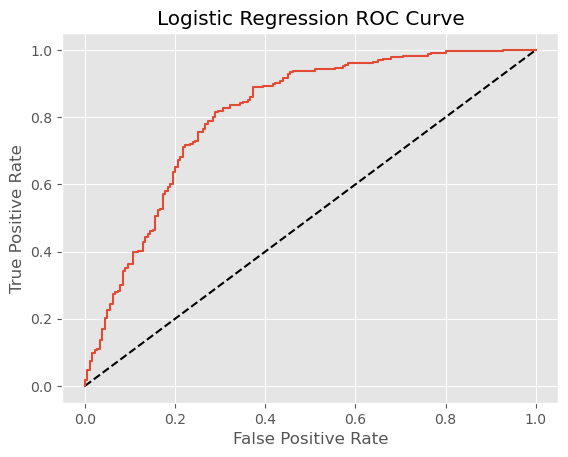

In [63]:
LR.roc_curve()

### Creating the models instances, with all the propertys included with the class we created, model develpment.

For this, we are going to create a function that takes in a model, the respective scaler. We are going to train either with the scaler on and off.


In [ ]:
models_instances = []
def create_models_instances(scaling=True):
    if scaling:
        for model in ModelParams.models_params.keys():
            models_instances.append(ModelDevelopment(model, model, X, y, scaler))
